# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('../../data/btc.csv')
print(df)
name_col='open'

     formatted_date          high           low          open         close  \
0        2019-01-01   3850.913818   3707.231201   3746.713379   3843.520020   
1        2019-01-02   3947.981201   3817.409424   3849.216309   3943.409424   
2        2019-01-03   3935.685059   3826.222900   3931.048584   3836.741211   
3        2019-01-04   3865.934570   3783.853760   3832.040039   3857.717529   
4        2019-01-05   3904.903076   3836.900146   3851.973877   3845.194580   
...             ...           ...           ...           ...           ...   
1420     2022-11-22  16253.047852  15656.606445  15782.300781  16189.769531   
1421     2022-11-23  16638.193359  16170.502930  16195.588867  16610.707031   
1422     2022-11-24  16771.474609  16501.767578  16611.636719  16604.464844   
1423     2022-11-25  16603.316406  16388.404297  16602.269531  16521.841797   
1424     2022-11-26  16666.863281  16521.164062  16524.724609  16620.326172   

           volume      adjclose  
0      4324200990

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')

,high,low,open,close,volume,adjclose,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
formatted_date,,,,,,,,,,,,,
2019-01-21,3608.840820,3558.537109,3600.372803,3576.032471,5004347059,3576.032471,50.303711,24.340332,3663.397775,3736.813407,3782.927804,42.763655,159.500358
2019-01-22,3620.746582,3539.721436,3575.081299,3604.577148,5313623556,3604.577148,81.025146,-29.495850,3644.949916,3704.428345,3774.754848,49.537467,165.724656
2019-01-23,3623.067871,3565.313965,3605.557129,3585.123047,5433755649,3585.123047,57.753906,20.434082,3641.242397,3674.000140,3763.152030,51.637677,168.752697
2019-01-24,3616.087402,3569.092773,3584.500244,3600.865479,5262869046,3600.865479,46.994629,-16.365234,3631.617990,3641.863630,3746.649728,55.463195,168.457386
2019-01-25,3612.927734,3575.597412,3607.390381,3599.765869,5265847539,3599.765869,37.330322,7.624512,3621.532261,3637.104701,3735.952125,51.931866,169.890592
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22,16253.047852,15656.606445,15782.300781,16189.769531,30726828760,16189.769531,596.441406,-407.468750,16532.192104,16752.973354,18064.344122,375.796355,1993.826306
2022-11-23,16638.193359,16170.502930,16195.588867,16610.707031,32958875628,16610.707031,467.690430,-415.118164,16433.798828,16585.246722,17860.183640,357.971385,1952.871009
2022-11-24,16771.474609,16501.767578,16611.636719,16604.464844,26129037414,16604.464844,269.707031,7.171875,16425.400391,16637.280901,17691.085891,352.136655,1896.456761


## Nạp dữ liệu từ file csv

In [5]:
df2 = pd.read_csv(f"../../predict/bitcoin_df_{name_col}.csv", parse_dates=True)
for i in range(0,len(df2)-1) :
    df2[name_col][i]=df2[name_col][i+1]

split_x = df2[['high','low','close','H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','close','H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(1124, 10) (1124, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(281, 10) (281, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradientboosting', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

{'estimators': (('lasso', Lasso(alpha=3.17, fit_intercept=False, max_iter=1, normalize=True,
      selection='random', tol=0.3)), ('gradientboosting', GradientBoostingRegressor(learning_rate=0.07, max_depth=8, n_estimators=1000,
                          subsample=0.3)), ('linear', LinearRegression()), ('ridge', Ridge(alpha=0.0006, fit_intercept=False, max_iter=1, normalize=False,
      positive=True))), 'final_estimator': ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)}


,high,low,close,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
60,4053.906738,4021.542480,4023.968262,32.364258,4.546387,4036.791783,3980.075387,3940.821684,38.611075,83.496834,2019-03-22,4019.978751
906,32218.406250,31100.673828,31421.539062,1117.732422,420.011719,33156.153739,33614.133789,33720.414900,794.016886,1118.000365,2021-07-16,31440.018757
1009,61435.183594,58208.187500,58482.386719,3226.996094,1869.613281,62083.112165,61405.303850,59333.182850,1963.627713,3594.673146,2021-10-27,58535.731274
746,38225.906250,36658.761719,38144.308594,1567.144531,-1212.761719,35018.866071,33725.025112,34285.107515,1675.764182,2088.230543,2021-02-05,38130.520562
1335,20127.234375,19387.492188,19419.505859,739.742188,707.728516,20596.678013,20321.034319,20199.361328,1041.749512,881.678848,2022-09-18,19414.236802


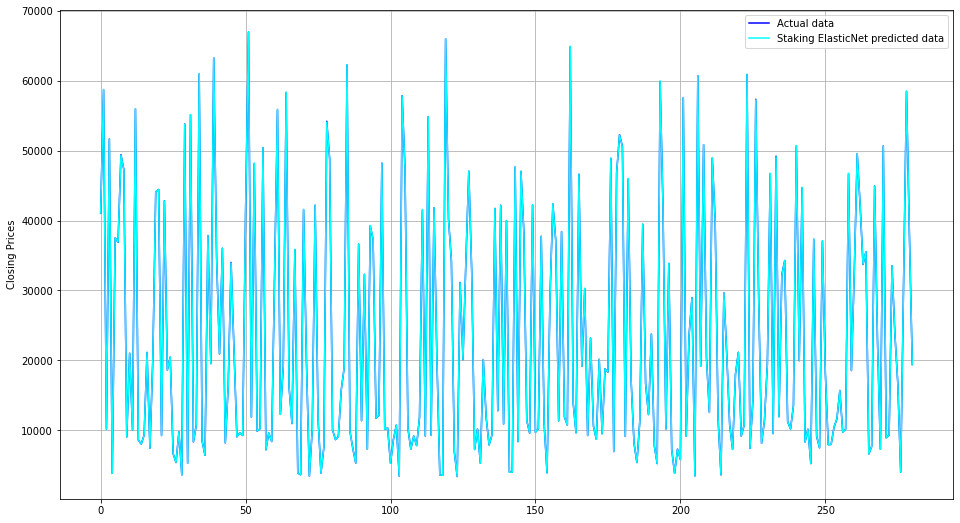

In [12]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [13]:
import pickle

In [14]:
filename = f'../../model/stacking/stacking_{name_col}.h5'
pickle.dump(elm_reg, open(filename, 'wb'))